<a href="https://colab.research.google.com/github/IlievskaMarija/EEGNet-target-object-detection/blob/main/eegnet_for_target_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Проект по предметот Интелигентни системи***

# 1. Вчитување на потребните библиотеки.






In [ ]:
!pip install tensorflow
!pip install mne

In [ ]:
import numpy as np
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')


# tools за генерирање на матрица на конфузија
from matplotlib import pyplot as plt

# Претпроцесирање
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from io import StringIO
import IPython.display
import mne
from scipy import signal
from sklearn import preprocessing
import csv

from collections import Counter
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Вчитување и процесирање на податоците за секој учесник и нивно зачувување во посебни фајлови.




 



>  
Претпроцесирање:
- **Butterworth Low Pass Filter** - Иако сигналот е веќе филтриран со 2–30 Hz band-pass филтер, се уште има шум во релативно повисоките фрекфенции, за да се ублажи овој шум, ќе направиме дополнителен 20 Hz Butterworth low-pass filter.
- **Downsampling** - Дополнително, сигналите се ресемплирани од 250Нz на 128Hz, со цел да се намали цената за процесирање, што резултира со 179 time samples  (точки) за еден настан.
- **Z-скор нормализација (стандардизација)** на сигналот на секоја од електродите правиме бидејќи невронските мрежи се зависни од вредностите на караткеристиките, односно доколку карактеристиките имаат голем ранг во кој се наоѓаат нивните вредности можат да се добијат полоши резултати. Затоа правиме нормализација на овие вредности со цел да добиеме модел на невронска мрежа кој што е многу подобар, односно тоа ќе доведе до поквалитетно тренирање во мрежата.

In [ ]:
def get_info_participant(number):
  #Вчитување на податоците од сите сесии
  mat1 = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+number+"/S01/Train/trainData.mat")
  mat2 = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+number+"/S02/Train/trainData.mat")
  mat3 = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+number+"/S03/Train/trainData.mat")
  
  #Претворање од (8,350,1600) во (1600,8,350)
  data1 = mat1['trainData'].transpose(2,0,1) 
  data2 = mat2['trainData'].transpose(2,0,1) 
  data3 = mat3['trainData'].transpose(2,0,1) 

  dataAll = np.concatenate((data1, data2, data3))

  data1 = csv.reader(open("/content/drive/My Drive/SBJ/SBJ"+number+"/S01/Train/trainTargets.txt", 'r'), delimiter=",")
  data2 = csv.reader(open("/content/drive/My Drive/SBJ/SBJ"+number+"/S02/Train/trainTargets.txt", 'r'), delimiter=",")
  data3 = csv.reader(open("/content/drive/My Drive/SBJ/SBJ"+number+"/S03/Train/trainTargets.txt", 'r'), delimiter=",")

  targets = []

  for row in data1:
      targets.append(int(row[0]))
  for row in data2:
      targets.append(int(row[0]))
  for row in data3:
      targets.append(int(row[0]))

  return dataAll, targets

In [ ]:
#Вчитување на податоците за сите учесници
list_data=[]
list_targets=[]
for p in range(1, 16):
  if p < 10:
    p='0'+str(p)
  data, targets = get_info_participant(str(p))
  list_data.append(data)
  list_targets.append(targets)

#Креирање на низа која ги содржи податоците за сите учесници
participants_data = np.asarray(list_data,np.float64)
#Креирање на низа која ги содржи податоците за сите учесници
participants_targets = np.asarray(list_targets,np.float64)
print(participants_data.shape)
print(participants_targets.shape)

#Препроцесирање на податоците
def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=6):
    normal_cutoff = float(cutoff_freq) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype = 'low')
    fs = signal.filtfilt(b, a, data)
    return fs


cutoff_frequency = 20.0
sample_rate = 250

x, y, z = data.shape
old_time_samples = z #350
old_fs = 250
new_fs = 128
new_time_samples = int((old_time_samples/old_fs)*new_fs) #(350/250)*128=179
tmp = [[[0 for k in range(new_time_samples)] for j in range(y)] for i in range(x)]

for p in range(1, 16):
  if p < 10:
    p='0'+str(p)
  processed_data = np.asarray(tmp,dtype=np.float64)
  data = participants_data[int(p)-1].copy()
  for i in range(x):
    for j in range(y):
      s = data[i][j]
      #Филтрирање со 20Hz 6th order Butterworth low-pass филтер
      filtered_signal = butter_lowpass_filter(s, cutoff_frequency, sample_rate/2)
      #Ресемплирање од 250Нz на 128Hz
      resampled_signal = scipy.signal.resample( filtered_signal, new_time_samples )
      #Z-скор нормализирање (стандардизирање)
      std_signal = preprocessing.scale(resampled_signal)
      processed_data[i][j] = std_signal

  #Зачувување на процесираните сигнали во фајлот processedTrainData.mat
  scipy.io.savemat("/content/drive/My Drive/SBJ/SBJ"+str(p)+"/processedTrainData.mat",{'processedTrainData':processed_data})

for p in range(1, 16):
  if p < 10:
    p='0'+str(p)
  t = participants_targets[int(p) - 1]
  #Зачувување на train targets од сите сесии во фајлот targets.mat
  scipy.io.savemat("/content/drive/My Drive/SBJ/SBJ"+str(p)+"/targets.mat",{'targets':t[1]})


(15, 4800, 8, 350)
(15, 4800)


# 3. Визуелизација на податоците.

*3.1. Визуелизација на податоците за првиот учесник*

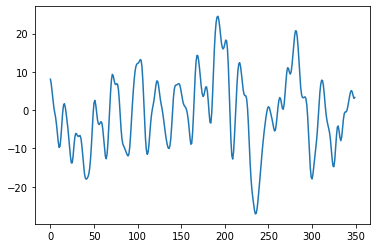

In [ ]:
number = '01'
data, targets=get_info_participant(number)
plt.plot(data[0][0]) 
plt.show()

Creating RawArray with float64 data, n_channels=8, n_times=350
    Range : 0 ... 349 =      0.000 ...     1.396 secs
Ready.


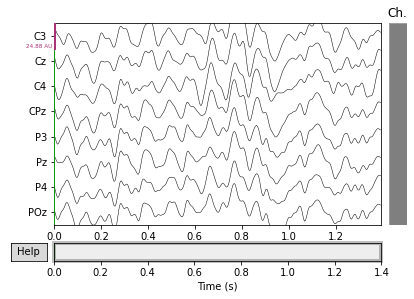

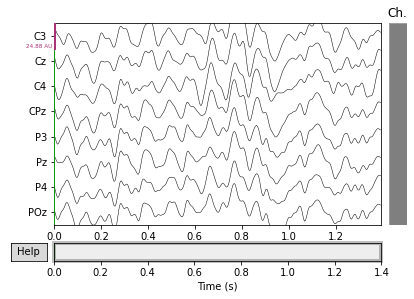

In [ ]:
ch_names = ['C3', 'Cz', 'C4', 'CPz', 'P3', 'Pz', 'P4', 'POz']    
sampling_freq = 250 
info = mne.create_info(ch_names, sampling_freq) 
#Визуелизација на сигналите од сите 8 канали за првиот настан
raw = mne.io.RawArray(data[0], info)  
raw.plot()

*3.2. Визуелизација на сигналот од последниот канал за последниот настан на последниот учесник.*

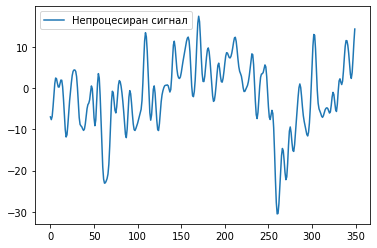

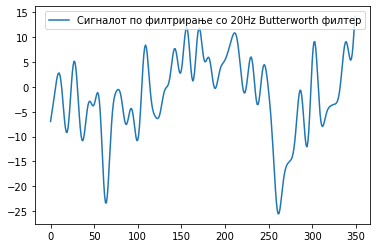

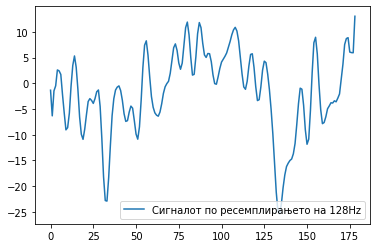

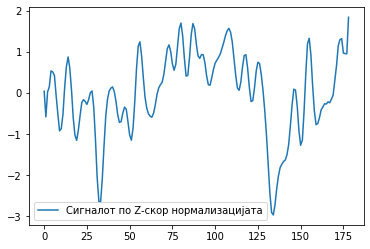

In [ ]:
#Визуелизација на сигналот од последниот канал за последниот настан
#Непроцесиран сигнал
plt.plot(s, label="Непроцесиран сигнал")
plt.legend()
plt.show()
#Сигналот по филтрирањето со 20Hz 6th order Butterworth low-pass филтер
plt.plot(filtered_signal, label="Сигналот по филтрирање со 20Hz Butterworth филтер")
plt.legend()
plt.show()
#Сигналот по ресемплирањето на 128Hz
plt.plot(resampled_signal, label="Сигналот по ресемплирањето на 128Hz")
plt.legend()
plt.show()
#Сигналот по Z-скор нормализацијата
plt.plot(std_signal, label="Сигналот по Z-скор нормализацијата")
plt.legend()
plt.show()

# 4. Тренирање на моделите.

* За декодирање на P300 сигналот ќе користиме EEGNet[1] која е компанктна CNN за EEG-базирани BCIs, дизајнирана да го намали бројот на тренирачки параметри со вклучувањето на Depthwise и Separable конволуции. Оваа мрежа претпоставува дека влезниот сигнал е семплиран на 128Hz, па затоа во фазата на претпроцесирање направивме соодветно ресемплирање.
* Оваа CNN вклучува 3 блока. Во првиот блок има два конволуциски слоја кои што прават temporal и depthwise spatial конволуции. Вториот блок има separable конволуциски слој и во последниот блок има fully-connected слој кој jа финализира бинарната класификација. Се користат Batch Normalization, Dropout, Exponential Linear Units (ELUs), а главните хипер-параметри се прикажани во табелата.
* Сите останати параметри на мрежата (K - number of kernels, F1 - number of temporal filters, F2 - number of pointwise filters, D - number of spatial filters to learn within each temporal convolution, F - size of the kernels, p - dropout rate) се подесени според спецификациите во [1].

```
________________________________________________________________________________
Layer (type)                 Output Shape        Hyper-parameters     Param #   
================================================================================
InputLayer                   (None, 1, 8, 179)                        0         
________________________________________________________________________________
Conv2D                       (None, 8, 8, 179)   K = 8                520 
                                                 F = (1, 65)        
________________________________________________________________________________
BatchNormalization           (None, 8, 8, 179)                        32        
________________________________________________________________________________
DepthwiseConv2D              (None, 16, 1, 179)  D = 2                128 
                                                 K = 16
                                                 F = (8, 1)             
________________________________________________________________________________
BatchNormalization           (None, 16, 1, 179)                       64        
________________________________________________________________________________
Activation                   (None, 16, 1, 179)                       0         
________________________________________________________________________________
AveragePooling2D             (None, 16, 1, 44)   F = (1, 4)           0         
________________________________________________________________________________
Dropout                      (None, 16, 1, 44)   p = 0.4              0         
================================================================================
SeparableConv2D              (None, 16, 1, 44)   K = 16               528
                                                 F = (1, 17)
________________________________________________________________________________
BatchNormalization           (None, 16, 1, 44)                        64        
________________________________________________________________________________
Activation                   (None, 16, 1, 44)                        0         
________________________________________________________________________________
AveragePooling2D             (None, 16, 1, 5)    F = (1, 8)           0         
_______________________________________________________________________________
Dropout                      (None, 16, 1, 5)    p = 0.4              0         
================================================================================
Flatten                      (None, 80)                               0         
________________________________________________________________________________
Dense                        (None, 2)                                162       
________________________________________________________________________________
Activation                   (None, 2)                                0         
================================================================================
Total params: 1,498
Trainable params: 1,418
Non-trainable params: 80
```

    [1] Lawhern, V.J., Solon, A.J., Waytowich, N.R., Gordon, S.M., Hung, C.P
    Lance, B.J.: EEGNet: a compact convolutional neural network for EEG-based
    braincomputer interfaces. J. Neural Eng. 15(5), 056013 (2018)
    Link: https://arxiv.org/pdf/1611.08024.pdf


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 8, Samples = 179, 
             dropoutRate = 0.5, F = 65, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    block1       = Conv2D(F1, (1, F), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False, activation = 'linear')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 17),
                                   use_bias = False, padding = 'same', activation = 'linear')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate), activation = 'linear')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

* Податоците се делат на 75% train и 25% validation. Балансирање на податоците 
за тренирање со undersampling користејќи RandomUnderSampler.


* Тренирање на моделите за сите учесници и запишување на резултатите од секоја сесија во output_format.csv.
  * Како функција на загуба користиме categorical_crossentropy која се користи за single label категоризации. Тоа се категоризациии каде само една категорија одговара на еден data point.
  * Како optimizer се користи Adam со default параметри, batch_size = 32 и 300 епохи. За справување со небалансираноста користиме undersampling, така што крајниот однос помеѓу класите е 4 : 1, со тоа што дополнително на класите им доделуваме и соодветни тежини.
  * За да спречиме потенцијален overfit покрај Dropout дополнително користиме и Early Stopping метода, при што како метрика се користи минимизација на validation loss.

In [ ]:
def get_test_participant(number, session):
  #Вчитување на податоците од сите сесии
  mat1 = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+number+"/S"+session+"/Test/testData.mat")
  #Претворање од (8,350,1600) во (1600,8,350)
  data1 = mat1['testData'].transpose(2,0,1) 
  dataAll = data1
  return dataAll

In [ ]:
def get_events_participant(number, session):
  data1 = csv.reader(open("/content/drive/My Drive/SBJ/SBJ"+number+"/S"+session+"/Test/testEvents.txt", 'r'), delimiter=",")    
  events = []
  for row in data1:
      events.append(int(row[0]))  
  return events  

In [ ]:
def mode(array):
    most = max(list(map(array.count, array)))
    return list(set(filter(lambda x: array.count(x) == most, array)))

**Output**
> Ф-ја која што го враќа посакуваниот output за секој учесник. Класификацискиот модел со predict враќа матрица со вероjатностите дека даден настан припаѓа на одредена класа (1 – P300, 0 – не е P300), коjа потоа
jа предаваме на функциjата argmax за да ги добиеме
предвидените класи.
Добиените единици и нули се множат со целните
настани и за секоj run се добива по еден настан коj
бил P300, потоа со наоѓање на модата од секоj run во
еден блок добиваме коj е целниот обjект во тоj блок,
односно на коj обjект учесникот посветил внимание во
соодветниот блок.


In [ ]:
def output_per_user_test(events, targets, rpb):

  testEvents = [int(e) for e in events]
  testTargets = [int(t) for t in targets]
  testEvents = np.array(events)
  testTargets = np.array(targets)
  labels = testEvents * testTargets #gi mnozhime targetite so pojavenite eventi so cel da ni ostanat samo eventite koi ni se target, ostanatite stanuvaat nuli
  outputs = []
  total_events = 8*rpb*50 #broj na eventi * broj na runs per block * broj na blokovi
  for i, j in zip(range(0, total_events, rpb*8), range(rpb*8, total_events+(rpb*8), rpb*8)): # gi mineme site 50 bloka od po rpb*8 events
    target_objects = [i for i in labels[i : j] if i != 0] #brishenje na nulite
    outputs.append(mode(target_objects)) #naogjanje moda od ostanatite elementi
  return outputs

In [ ]:
for p in range(1, 16):
  if(p < 10):
    p='0'+str(p)

  processed_data = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+str(p)+"/processedTrainData.mat")['processedTrainData']
  t = scipy.io.loadmat("/content/drive/My Drive/SBJ/SBJ"+str(p)+"/targets.mat")['targets']
  print(processed_data.shape)
  targets = t.reshape(-1)
  print(len(targets))

  x, y, z = processed_data.shape

  train_data=processed_data[0:int(x*0.75),:,:]
  train_targets=targets[0:int(x*0.75)]
  print(train_data.shape)

  validation_data=processed_data[int(x*0.75):,:,:]
  validation_targets=targets[int(x*0.75):]
  print(validation_data.shape)
  print(len(validation_targets))

  X1=np.reshape(train_data,(train_data.shape[0],train_data.shape[1]*train_data.shape[2]))
  print(train_data.shape)
  y1 = train_targets
  undersample = RandomUnderSampler(sampling_strategy=0.25)
  X_over, y_over = undersample.fit_resample(X1, y1)
  print('Resampled dataset shape %s' % Counter(y_over))

  # Враќање во 3D
  final2=np.reshape(X_over,(X_over.shape[0],8,179))
  print(final2.shape)

  final, targets = shuffle(final2,y_over,random_state=0)

  x, y, z = processed_data.shape
  # содржи 8 канали и 179 time-points
  kernels, chans, samples = 1, 8, 179
  X_train      = final
  Y_train      = targets
  X_validate   = validation_data
  Y_validate   = validation_targets

  # претворање на лабелите во one-hot encodings бидејќи label encoding-от 
  # претпоставува дека колку е поголема категориската вредност, толку е подобра 
  # категоријата што и не мора да значи.
  # https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
  Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
  Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
  # Y_test       = np_utils.to_categorical(Y_test, num_classes=2)

  # претворање на податоците во формат (events, kernels, channels, samples)
  X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
  X_validate   = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
  # X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)


  print('X_train shape:', X_train.shape)
  print(X_train.shape[0], 'train samples')
  # print(X_test.shape[0], 'test samples')


  model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
                dropoutRate = 0.4, F = 65,  D = 2,
                dropoutType = 'Dropout')

  print(model.summary())

  # compile the model and set the optimizers
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics = ['accuracy'])


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  class_weights = {0:1, 1:4}

  fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, 
                          verbose = 2,validation_data=(X_validate, Y_validate)
                          ,callbacks=[es], class_weight = class_weights)

  for l in range(1, 4):
    l='0'+str(l)
    data_t=get_test_participant(str(p), l)
    # print(data_t.shape)

    x, y, z = data_t.shape
    new_time_samples = int((old_time_samples/old_fs)*new_fs) #(350/250)*128=179
    tmp = [[[0 for k in range(new_time_samples)] for j in range(y)] for i in range(x)]
    processed_data_t = np.asarray(tmp,dtype=np.float64)

    for i in range(x):
      for j in range(y):
        s = data_t[i][j].copy()
        #Филтрирање со 20Hz 6th order Butterworth low-pass филтер
        filtered_signal = butter_lowpass_filter(s, cutoff_frequency, sample_rate/2)
        #Ресемплирање од 250Нz на 128Hz
        resampled_signal = scipy.signal.resample(filtered_signal, new_time_samples )
        #Z-скор нормализирање (стандардизирање)
        std_signal = preprocessing.scale(resampled_signal)
        processed_data_t[i][j] = std_signal

    test_data=processed_data_t

    events = get_events_participant(str(p), l)
    X_test = test_data
    X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)
    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  



    reader = csv.reader(open("/content/drive/My Drive/SBJ/SBJ"+str(p)+"/S"+l+"/Test/runs_per_block.txt", 'r'), delimiter=",")
    rpb = int(list(reader)[0][0])
    # print(rpb)

    # print(output_per_user_test(events, preds, rpb))

    listlist = output_per_user_test(events, preds, rpb)
    outputs = []
    for i in range(0, len(listlist)):
      outputs.append(listlist[i][0])

    print(outputs)

    import csv
    out = []
    with open("/content/drive/My Drive/output_format.csv" ) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            out = list(csv_reader)
            for i in range(len(outputs)):
              out[(int(p)-1)*3+int(l)][i+2] = outputs[i]

    with open("/content/drive/My Drive/output_format.csv", 'w' ) as csv_file:
      csv_writer = csv.writer(csv_file, delimiter=',')
      for row in out:
        csv_writer.writerow(row)



(4800, 8, 179)
4800
(3600, 8, 179)
(1200, 8, 179)
1200
(3600, 8, 179)
Resampled dataset shape Counter({0.0: 1800, 1.0: 450})
(2250, 8, 179)
X_train shape: (2250, 1, 8, 179)
2250 train samples
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8, 179)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 179)         520       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 179)         32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 179)        128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 179)        64        
_________________________________________________________________
a

In [ ]:
with open("/content/drive/My Drive/output_format.csv" ) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        out = list(csv_reader)
        for row in out:
          print(row)

In [ ]:
import csv
out_data = csv.reader(open("/content/drive/My Drive/prikacen_output_format.csv", 'r'), delimiter=",")
next(out_data)
out_data_list = []
for row in out_data:
  for i in range(2, len(row)):
    out_data_list.append(int(row[i]))
print(len(out_data_list))

true_data = csv.reader(open("/content/drive/My Drive/true_labels.csv", 'r'), delimiter=",")
next(true_data)
true_data_list = []
for row in true_data:
  for i in range(2, len(row)):
    true_data_list.append(int(row[i]))
print(len(true_data_list))

acc         = np.mean(np.asarray(out_data_list) == np.asarray(true_data_list))
print("Classification accuracy on example test data: %f " % (acc))

from sklearn.metrics import classification_report
print(classification_report(true_data_list, out_data_list))


2250
2250
Classification accuracy on example test data: 0.862222 
              precision    recall  f1-score   support

           1       0.80      0.94      0.87       278
           2       0.87      0.90      0.88       296
           3       0.84      0.94      0.89       300
           4       0.87      0.87      0.87       281
           5       0.90      0.69      0.78       261
           6       0.90      0.81      0.85       256
           7       0.92      0.83      0.87       287
           8       0.83      0.90      0.86       291

    accuracy                           0.86      2250
   macro avg       0.87      0.86      0.86      2250
weighted avg       0.87      0.86      0.86      2250



[]

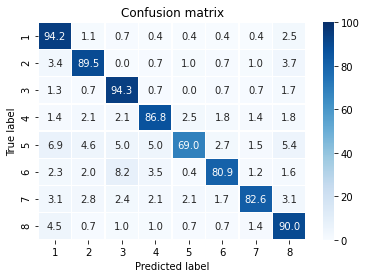

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(true_data_list,out_data_list)
names = ['1', '2', '3', '4', '5', '6', '7', '8']
# plt.figure(0)
cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(data=cm, columns=names, index=names)
g = sn.heatmap(df, annot=True, fmt=".1f", linewidths=.5, vmin=0, vmax=100,
                    cmap='Blues')
g.set_title('Confusion matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')
g.plot()